In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "8"

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


In [3]:
# from PIL import Image
# import os

# arr = []

# def resize_and_compress_images(directory, target_width, target_height, quality=85):
#     """
#     지정된 디렉토리 내의 모든 이미지의 크기를 조정하고 압축하여 저장합니다.
    
#     Args:
#     directory (str): 이미지 파일이 있는 디렉토리의 경로.
#     target_width (int): 변경할 이미지의 너비.
#     target_height (int): 변경할 이미지의 높이.
#     quality (int): 저장할 이미지의 품질 (JPEG 품질).
#     """
#     # 지정된 디렉토리에서 모든 파일 목록을 가져옵니다.
#     files = os.listdir(directory)
#     # 이미지 파일만 필터링합니다.
#     img_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
#     # 각 이미지 파일에 대해 반복 처리합니다.
#     for file in img_files:
#         # 원본 이미지 경로
#         old_path = os.path.join(directory, file)
#         # 이미지를 엽니다.
#         try:
#             with Image.open(old_path) as img:
#                 # 이미지 크기를 변경합니다.
#                 img = img.resize((target_width, target_height))
#                 # 변경된 이미지를 같은 경로에 저장합니다. 확장자를 '.jpg'로 통일하여 JPEG으로 저장합니다.
#                 new_path = os.path.join(directory, os.path.splitext(file)[0] + '.jpg')
#                 img.save(new_path, 'JPEG', quality=quality)
#                 print(f"Resized and saved '{old_path}' to '{new_path}'")
#         except Exception as e:
#             print(f"Failed to process '{old_path}': {e}")
#             arr.append([os.path.splitext(file)[0]])

# # 사용 예:
# for label in ['glass', 'metal', 'trash', 'plastic']:
#     directory = './dataset/' + label  # 이미지가 저장된 폴더 경로
#     target_width = 800  # 변경할 이미지의 너비
#     target_height = 600  # 변경할 이미지의 높이
#     resize_and_compress_images(directory, target_width, target_height)

# print(arr)
# print()


In [19]:
# 데이터셋 위치 정보
dataset_path = "../final_dataset/"

# 데이터셋 라벨 정보
dataset_labels = os.listdir(dataset_path)

## pandas 사용하여 데이터프레임 생성
data = []

for garbage_label in dataset_labels:
    # garbage_label 내부 이미지 파일들을 [파일명 | 라벨 ] 형식으로 data 폴더에 append
    for file in os.listdir(os.path.join(dataset_path, garbage_label)):    # garbage_label 파일 경로를 나타내고 있음
        data.append((os.path.join(dataset_path, garbage_label, file), garbage_label))

garbage_df = pd.DataFrame(data, columns=['filepath', 'label'])

garbage_df.head()
# print(len(garbage_df))
# print(garbage_df)

,filepath,label
0,../final_dataset/glass/glass901.jpg,glass
1,../final_dataset/glass/glass298.jpg,glass
2,../final_dataset/glass/glass3100.jpg,glass
3,../final_dataset/glass/glass75.jpg,glass
4,../final_dataset/glass/glass1335.jpg,glass


In [20]:
# 데이터프레임을 training set, validation set으로 나눔
train_df, test_df = train_test_split(garbage_df, test_size=0.1, random_state=42, stratify=garbage_df['label'])   # random_state : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값
                                                                                                                # stratify : 클래스 label 비율을 동일하게 유지
print(f"Number of the training set : {len(train_df)}")
print(f"Number of the validation set : {len(test_df)}")

Number of the training set : 12518
Number of the validation set : 1391


In [21]:
# 1. Class distribution in the entire dataset
overall_distribution = garbage_df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = test_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
plastic    28.63
metal      28.52
glass      28.48
trash      14.37
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
plastic    28.63
metal      28.52
glass      28.48
trash      14.37
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
plastic    28.61
metal      28.54
glass      28.47
trash      14.38
Name: proportion, dtype: float64


In [22]:
# training data augmentation 실행
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    channel_shift_range=10,
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# validation data rescaliling
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col="filepath",                   # 데이터프레임에서 이미지 파일의 경로를 포함하는 컬럼의 이름
    y_col="label",                      # 데이터프레임에서 라벨 데이터를 포함하는 컬럼의 이름
    target_size = (384, 384),           # 이미지 사이즈
    batch_size = 256,                    # 한 번에 네트워크에 전달될 샘플의 수
    class_mode = 'categorical',         # 다중 이미지 분류에서 categorical이 유용함
    seed = 42,                          # 랜덤 난수 데이터 설정
    shuffle = False,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col="filepath",                   # 데이터프레임에서 이미지 파일의 경로를 포함하는 컬럼의 이름
    y_col="label",                      # 데이터프레임에서 라벨 데이터를 포함하는 컬럼의 이름
    target_size = (384, 384),           # 이미지 사이즈
    batch_size = 256,                    # 한 번에 네트워크에 전달될 샘플의 수
    class_mode = 'categorical',         # 다중 이미지 분류에서 categorical이 유용함
    seed = 42,                          # 랜덤 난수 데이터 설정
    shuffle = False,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col="filepath",                   # 데이터프레임에서 이미지 파일의 경로를 포함하는 컬럼의 이름
    y_col="label",                      # 데이터프레임에서 라벨 데이터를 포함하는 컬럼의 이름
    target_size = (384, 384),           # 이미지 사이즈
    batch_size = 256,                    # 한 번에 네트워크에 전달될 샘플의 수
    class_mode = 'categorical',         # 다중 이미지 분류에서 categorical이 유용함
    seed = 42,                          # 랜덤 난수 데이터 설정
    shuffle = False
)


print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(validation_generator)}")
print(f"Number of batches in test_generator: {len(test_generator)}")

Found 10014 validated image filenames belonging to 4 classes.
Found 2503 validated image filenames belonging to 4 classes.
Found 1390 validated image filenames belonging to 4 classes.
Number of batches in train_generator: 40
Number of batches in val_generator: 10
Number of batches in test_generator: 6


/home/j-k10c206/.local/lib/python3.9/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
/home/j-k10c206/.local/lib/python3.9/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(
/home/j-k10c206/.local/lib/python3.9/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [23]:
from sklearn.utils.class_weight import compute_class_weight

# class label값 추출
class_labels = train_df['label'].unique()

weights = compute_class_weight(class_weight = "balanced", classes=class_labels, y = train_df['label'])

# print(train_generator.class_indices)
class_weights = dict(zip(train_generator.class_indices.values(), weights))
print(class_weights)

{0: 0.8778401122019636, 1: 0.8731863839285714, 2: 0.8766106442577031, 3: 1.7395775430794886}


In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

In [25]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [26]:
input_shape = (384, 384, 3)
num_classes = 4

conv_base = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

input = conv_base.input
# # convolution block 4개만 frozen 시키고, 마지막 block만 fine tuning 진행
# for i, layer in enumerate(conv_base.layers):
#     print(i, layer.name)      # block_4_output = 142번째까지

# block_4 레이어까지 frozen
for layer in conv_base.layers[:152]:
    layer.trainable = False

x = conv_base.output
x = GlobalAveragePooling2D()(x)
dropout = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(dropout)

final_model = Model(inputs = input, outputs = output)

final_model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

final_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 390, 390, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 192, 192, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 96, 96, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 96, 96, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 96, 96, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 96, 96, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 48, 48, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 48, 48, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 48, 48, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 48, 48, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 24, 24, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 24, 24, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 24, 24, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 24, 24, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 24, 24, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 24, 24, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 24, 24, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 24, 24, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv5_block1_add (Add)         (None, 12, 12, 2048  0           ['conv5_block1_0_bn[0][0]',      
                                )                                 'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 12, 12, 2048  0           ['conv5_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 12, 12, 512)  1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 12, 12, 512)  2048       ['conv5_block2_1_conv[0][0]']    
 ization) 

/home/j-k10c206/.local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                )                                                                 
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 dropout_1 (Dropout)            (None, 2048)         0           ['global_average_pooling2d_1[0][0
                                                                 ]']                              
                                                                                                  
 dense_1 (Dense)                (None, 4)            8196        ['dropout_1[0][0]']              
                                                                                                  
Total para

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

# Total number of epochs
num_epochs = 100
batch_size = 256

# Train the model
# history = final_model.fit(train_generator,
#                         steps_per_epoch=len(train_generator),
#                         epochs=num_epochs,
#                         validation_data=validation_generator,
#                         validation_steps=len(validation_generator),
#                         class_weight=class_weights,
#                         callbacks=[reduce_lr, early_stopping])

history = final_model.fit(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_data=validation_generator,
                        validation_steps=len(validation_generator),
                        class_weight=class_weights,
                        callbacks=[reduce_lr, early_stopping])


final_model.save("cnn_V2(batch_size_256_lr_e-3).h5")

Epoch 1/100


2024-05-17 08:51:59.605149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2024-05-17 08:52:00.420356: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


40/40 [==============================] - 400s 10s/step - loss: 0.5247 - accuracy: 0.7841 - val_loss: 6.3673 - val_accuracy: 0.5022 - lr: 0.0010
Epoch 2/100
40/40 [==============================] - 385s 10s/step - loss: 0.2690 - accuracy: 0.8944 - val_loss: 7.0341 - val_accuracy: 0.4970 - lr: 0.0010
Epoch 3/100
40/40 [==============================] - 385s 10s/step - loss: 0.2080 - accuracy: 0.9131 - val_loss: 1.0753 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 4/100
40/40 [==============================] - 385s 10s/step - loss: 0.1731 - accuracy: 0.9300 - val_loss: 0.7394 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 5/100
40/40 [==============================] - 384s 10s/step - loss: 0.1442 - accuracy: 0.9418 - val_loss: 0.2500 - val_accuracy: 0.9177 - lr: 0.0010
Epoch 6/100
40/40 [==============================] - 385s 10s/step - loss: 0.1385 - accuracy: 0.9425 - val_loss: 0.6078 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 7/100
40/40 [==============================] - 385s 10s/step - loss: 0

6/6 [==============================] - 9s 1s/step - loss: 0.1888 - accuracy: 0.9604
Loss = 0.18881
Accuracy = 0.96043
6/6 [==============================] - 8s 1s/step
              precision    recall  f1-score   support

       glass       0.95      0.97      0.96       396
       metal       0.96      0.96      0.96       396
     plastic       0.96      0.93      0.94       398
       trash       0.99      1.00      1.00       200

    accuracy                           0.96      1390
   macro avg       0.96      0.97      0.96      1390
weighted avg       0.96      0.96      0.96      1390





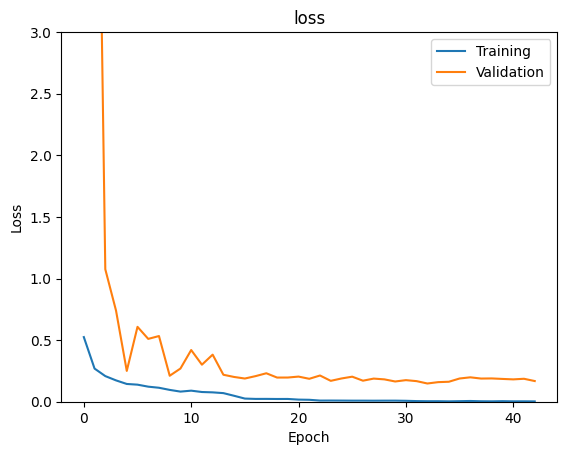

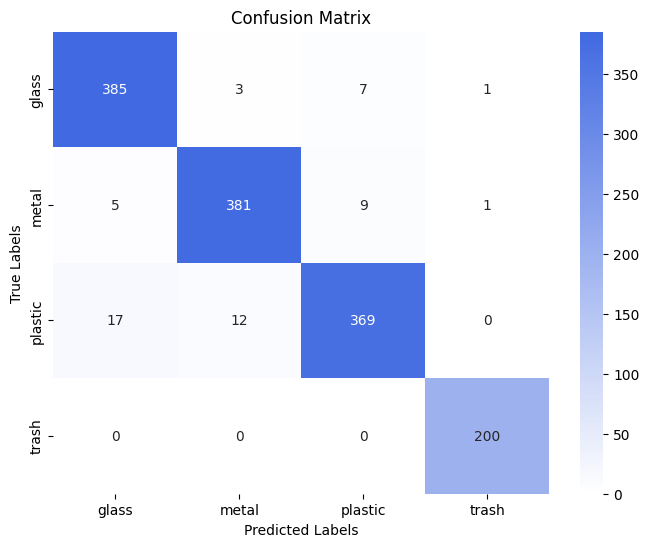

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_loss(h, title="loss"):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 3)
    plt.legend(['Training', 'Validation'], loc=0)


def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix(learning rate : 1e-3 | )')
    plt.show()


    
plot_loss(history)

loss, accuracy = final_model.evaluate(test_generator, steps=len(test_generator))
print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

evaluate_model_performance(final_model, test_generator, class_labels)




In [14]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model  


def prepare_image(file_path, output_size=(384, 384)):
    # 이미지를 불러옵니다.
    img = cv2.imread(file_path)

    # 이미지 사이즈 조절
    desired_size = 275
    old_size = img.shape[:2]
    if max(old_size) < desired_size:
        ratio = float(desired_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        img = cv2.resize(cropped_image, (new_size[1], new_size[0]))


    h, w, _ = img.shape
    # 새 이미지의 크기를 설정합니다.
    new_h, new_w = output_size

    # 배경 이미지를 생성합니다. 여기서는 흰색 배경을 사용합니다.
    result = np.full((new_h, new_w, 3), 255, dtype=np.uint8)

    # 새 이미지에서 원본 이미지가 위치할 시작점을 계산합니다.
    x_center = (new_w - w) // 2
    y_center = (new_h - h) // 2

    # 원본 이미지를 새 이미지의 중앙에 위치시킵니다.
    result[y_center:y_center+h, x_center:x_center+w] = img

    # 이미지를 RGB 형식으로 변환합니다.
    img_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
#     cv2.imwrite(img_rgb)
    plt.imshow(img_rgb)
    plt.show()

    # 이미지를 numpy 배열로 변환합니다.
    img_array = image.img_to_array(img_rgb)

    # 데이터 형식을 float32로 변경합니다.
    img_array = img_array.astype('float32')

    # 차원을 확장하여 모델 입력에 맞춥니다.
    img_array = np.expand_dims(img_array, axis=0)

    # 입력 이미지 배열을 전처리합니다.
    img_array = preprocess_input(img_array)

    return img_array

In [15]:
def classify_garbage(image_path):
    # 예를 들어 이미지 경로
    # img_path = './test_data/test4.jfif'

    # 이미지 전처리
    prepared_image = prepare_image(image_path)

    model = load_model("../models/cnn(batch_size_256_lr_e-3).h5", compile=False)

    class_names = open("./labels.txt", "r", encoding='UTF8').readlines()

    # 모델을 사용하여 예측
    predictions = model.predict(prepared_image)
    predicted_class = np.argmax(predictions, axis=1)[0]

    print("predicted_class:", predicted_class)

    class_name = class_names[predicted_class]
    garbage_class_name = class_name[2:-1]

    # print(f"Predicted class: {class_labels[predicted_class]}")

    return garbage_class_name, predicted_class

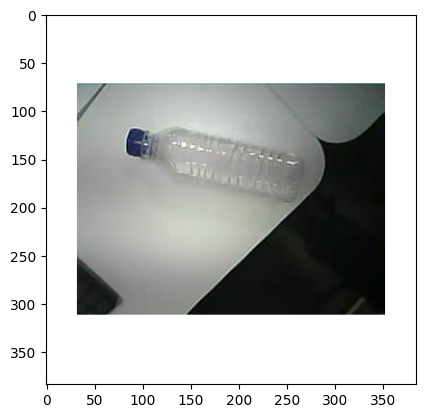

1/1 [==============================] - 1s 978ms/step
predicted_class: 3
종류: NORMAL
인덱스:  3


In [16]:
class_name, class_idx = classify_garbage('./image5.jpg')
print("종류: " + class_name)
print("인덱스: ", class_idx)